In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,expr

In [2]:
spark = (spark.builder.appName("sale_data").getOrCreate())

câu hỏi 1: đọc dữ liệu 2019 từ file parquet

In [3]:
source_data_path = "challenge2/"
partition = "Year=2019"
full_path = f"{source_data_path}{partition}"

In [4]:
sale2019_df = spark.read.parquet(full_path)
sale2019_df.show()

+--------------------+--------------------+--------------+-----+--------+------------+---------+-------------------+-----+
|             Product|        StoreAddress|          City|State|Order_ID|Quantity_pro|Price_pro|         Order_Date|Month|
+--------------------+--------------------+--------------+-----+--------+------------+---------+-------------------+-----+
|  Macbook Pro Laptop|136 Church St, Ne...| New York City|   NY|  295665|           1|     1700|2019-12-30 00:01:00|   12|
|  LG Washing Machine|562 2nd St, New Y...| New York City|   NY|  295666|           1|      600|2019-12-29 07:03:00|   12|
|USB-C Charging Cable|277 Main St, New ...| New York City|   NY|  295667|           1|       11|2019-12-12 18:21:00|   12|
|    27in FHD Monitor|410 6th St, San F...| San Francisco|   CA|  295668|           1|      149|2019-12-22 15:13:00|   12|
|USB-C Charging Cable|43 Hill St, Atlan...|       Atlanta|   GA|  295669|           1|       11|2019-12-18 12:38:00|   12|
|AA Batteries (4

## câu hỏi 2 là: tháng nào thuận lợi nhất để sale 

In [5]:
!pip install seaborn=0.11
!pip install pandas
!pip install matplotlib

ERROR: Invalid requirement: 'seaborn=0.11'
Hint: = is not a valid operator. Did you mean == ?
You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [6]:
from pyspark.sql.functions import round, sum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sale_df = (sale2019_df.select(
                            col("Order_ID"),
                            col("Month"),
                            col("Price_pro"),
                            col("Quantity_pro"),
                            expr("Price_pro * Quantity_pro").alias("Sales")))

In [8]:
sale_df.show(10)

+--------+-----+---------+------------+-----+
|Order_ID|Month|Price_pro|Quantity_pro|Sales|
+--------+-----+---------+------------+-----+
|  295665|   12|     1700|           1| 1700|
|  295666|   12|      600|           1|  600|
|  295667|   12|       11|           1|   11|
|  295668|   12|      149|           1|  149|
|  295669|   12|       11|           1|   11|
|  295670|   12|        3|           1|    3|
|  295671|   12|       11|           1|   11|
|  295672|   12|       11|           2|   22|
|  295673|   12|       99|           1|   99|
|  295674|   12|        2|           4|    8|
+--------+-----+---------+------------+-----+
only showing top 10 rows



thấy rằng ta cần so sánh tháng thì phải xem xét tháng

In [9]:
 sale_df = (sale_df
           .groupBy("Month")
           .agg(round(sum("Sales"),2).alias("Total Sale"))
           .orderBy("Total Sale",ascending=False))

In [10]:
sale_df.show()

+-----+----------+
|Month|Total Sale|
+-----+----------+
|   12|   4591824|
|   10|   3719205|
|    4|   3374951|
|   11|   3184394|
|    5|   3138287|
|    3|   2794068|
|    7|   2635443|
|    6|   2566187|
|    8|   2234194|
|    2|   2191696|
|    9|   2087435|
|    1|   1805316|
+-----+----------+



nhìn qua ta thấy ngay được rằng tháng 12 là tháng mà nên sale nhất

In [11]:
pandas_df = (sale_df.orderBy("Month")).toPandas()

In [12]:
pandas_df

,Month,Total Sale
0,1,1805316
1,2,2191696
2,3,2794068
3,4,3374951
4,5,3138287
5,6,2566187
6,7,2635443
7,8,2234194
8,9,2087435
9,10,3719205


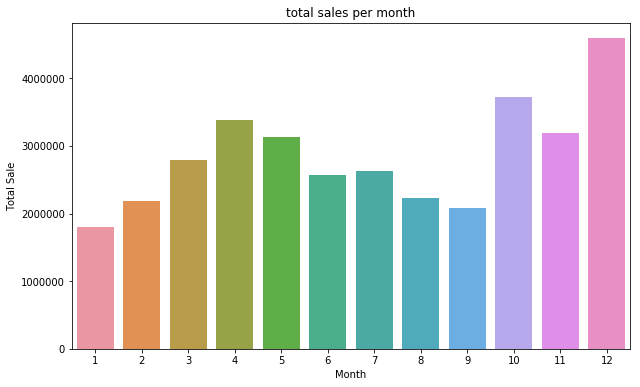

In [13]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False,style="plain")
sns.barplot(x="Month",y="Total Sale",data=pandas_df).set_title("total sales per month")
plt.ylabel("Total Sale")
plt.show()

In [18]:
sale_dim = spark.read.format("csv").option("header",True).load("export.csv")
sale_dim.printSchema

<bound method DataFrame.printSchema of DataFrame[Year: string, Month: string, DayofMonth: string, DayOfWeek: string, DepTime: string, CRSDepTime: string, ArrTime: string, CRSArrTime: string, UniqueCarrier: string, FlightNum: string, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: string, TaxiIn: string, TaxiOut: string, Cancelled: string, CancellationCode: string, Diverted: string, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]>

In [20]:
df_join = sale2019_df.join(sale_dim,sale2019_df.Month ==  sale_dim.Month,"inner");
df_join.explain()

== Physical Plan ==
*(2) BroadcastHashJoin [Month#8], [cast(Month#413 as int)], Inner, BuildRight
:- *(2) ColumnarToRow
:  +- FileScan parquet [Product#0,StoreAddress#1,City#2,State#3,Order_ID#4,Quantity_pro#5,Price_pro#6,Order_Date#7,Month#8] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex[file:/D:/CODE/python/spark3/Section4/challenge2/Year=2019], PartitionFilters: [isnotnull(Month#8)], PushedFilters: [], ReadSchema: struct<Product:string,StoreAddress:string,City:string,State:string,Order_ID:int,Quantity_pro:int,...
+- BroadcastExchange HashedRelationBroadcastMode(List(cast(cast(input[1, string, true] as int) as bigint))), [id=#237]
   +- *(1) Project [Year#412, Month#413, DayofMonth#414, DayOfWeek#415, DepTime#416, CRSDepTime#417, ArrTime#418, CRSArrTime#419, UniqueCarrier#420, FlightNum#421, TailNum#422, ActualElapsedTime#423, CRSElapsedTime#424, AirTime#425, ArrDelay#426, DepDelay#427, Origin#428, Dest#429, Distance#430, TaxiIn#431, TaxiOut#432, Cancel